Thermal Stokes Sinker
======

Demonstration example for setting up particle swarms with different material properties. This system consists of a dense, high viscosity sphere falling through a background lower density and viscosity fluid. 

**This lesson introduces the concepts of:**
1. Creating particle swarms.
2. Associating different behaviours with different particles.
3. Using the ``branching.conditional`` function.
4. Advecting particle swarms in a Stokes system.
5. Calibrating the stokes pressure solution using a solver callback routine. `callback_post_solve`

**Keywords:** particle swarms, Stokes system, advective diffusive systems, pressure calibration 


![title](./images/05_matvel.png)

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
import math
import pathlib

Setup parameters
-----

Set simulation parameters for the test and position of the spherical sinker.

In [2]:
# Set the resolution.
res = 64

#
expt_name = "RefCase-sinker-Dx0.5"
pathlib.Path(expt_name).mkdir(parents=True, exist_ok=True)

# Set size and position of dense sphere.
sphereRadius = 0.075*0.5
sphereCentre = (0.25, 0.375)

Create mesh and finite element variables
------

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0.0, 0.0), 
                                 maxCoord    = (0.5, 0.5))

velocityField       = mesh.add_variable(nodeDofCount=2 )
pressureField       = mesh.subMesh.add_variable(nodeDofCount=1 )

temperatureField    = mesh.add_variable( nodeDofCount=1 )
temperatureDotField = mesh.add_variable(nodeDofCount=1 ) # required for (SUPG)


Set initial conditions and boundary conditions
----------

Initialise the velocity and pressure fields to zero.
Construct sets for the both horizontal and vertical walls to define conditons for underworld solvers.

In [4]:
velocityField.data[:] = [0.0,0.0]
pressureField.data[:] = 0.0
temperatureField.data[:] = 0.5
temperatureDotField.data[:] = 0.0

In [5]:
coords = mesh.data

in_sphere = np.hypot((coords - sphereCentre)[:,0], (coords - sphereCentre)[:,1]) < sphereRadius

temperatureField.data[in_sphere] = 0.0

In [6]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )

In [7]:
temperatureField.data[mesh.specialSets["MaxJ_VertexSet"]] = 0.0 # top
temperatureField.data[mesh.specialSets["MinJ_VertexSet"]] = 1.0 # bottom

# Temperature is held constant on the jWalls
tempBC = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                           indexSetsPerDof = (jWalls,) )

Create a particle swarm
------

Swarms refer to (large) groups of particles which can advect with the fluid flow. These can be used to determine 'materials' as they can carry local information such as the fluid density and viscosity.

**Setup a swarm**

To set up a swarm of particles the following steps are needed:
1. Initialise and name a swarm, here called ``swarm``.
2. Define data variable (``materialIndex``) to store an index that will state what material a given particle is.
3. Populate the swarm over the whole domain using the layout command, here this is used to allocate 20 particles in each element.

In [8]:
# Create the swarm and an advector associated with it
swarm  = uw.swarm.Swarm( mesh=mesh )
swarm0 = uw.swarm.Swarm( mesh=mesh )

advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

# Go ahead and populate the swarm.

theta = np.linspace(0.0,2.0*np.pi, 360)
coords = np.zeros((theta.shape[0], 2))

coords[:,0] = sphereCentre[0] + sphereRadius * np.cos(theta)
coords[:,1] = sphereCentre[1] + sphereRadius * np.sin(theta)
    
valid = swarm.add_particles_with_coordinates(coords)
valid = swarm0.add_particles_with_coordinates(coords)



**Plot the particles by material**

Plot the initial positions of all swarm particles coloured by their material indices.


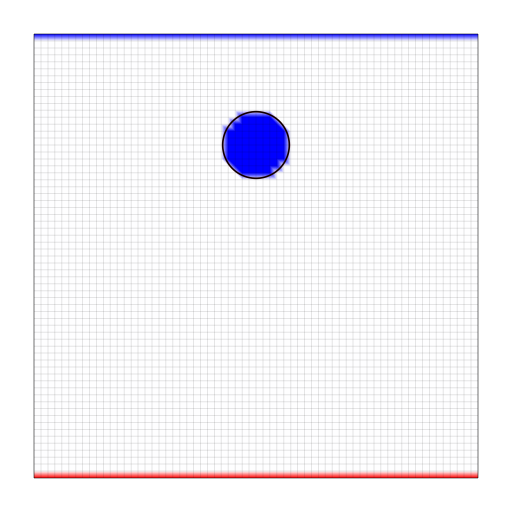

In [9]:
fig1 = glucifer.Figure( figsize=(512,512) )
fig1.Points(swarm,  colourBar=False, pointSize=2.0)
fig1.Points(swarm0, colourBar=False, pointSize=2.0, colour="Red")
fig1.VectorArrows(mesh, velocityField)
fig1.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red", colourBar=False)  )
fig1.append( glucifer.objects.Mesh(mesh, opacity=0.1))
fig1.show()

Set up material parameters and functions
-----

Here the functions for density and viscosity are set using the ``map`` function. This function evaluates a key function (here the material index), and the result (i.e. the key) is used to determine which function to evaluate to obtain the actual result (such as the particle density). 

For example if the material index of a particle is the light index number then the viscosity for that particle will be set to 1. If it had the heavy index number then it will be set to ``visc_sphere``, which can be either a function (say depending on temperature) or a constant as it is below.

The same approach is taken when setting up the density function for each particle in the swarm.

In [10]:
# Set constants for the viscosity and density of the sinker.

visc0 = 1.0
viscCoeff = 0.0
densitySphere = 10.0

viscFn = visc0 * fn.math.exp(-temperatureField*viscCoeff)

# And the final buoyancy force function.
z_hat = ( 0.0, 1.0 )
gravity = 1.0
density0 = 1.0
buoyancyFn = -density0 * gravity * (1.0-temperatureField) * z_hat

System setup
-----

**Setup a Stokes system**

In [11]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = freeslipBC,
                               fn_viscosity  = viscFn, 
                               fn_bodyforce  = buoyancyFn )

solver = uw.systems.Solver( stokes )

In [12]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0e-5, 
                                         _allow_non_q1  = True,
                                         conditions     = tempBC )

In [13]:
top = mesh.specialSets["MaxJ_VertexSet"]
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

# a callback function to calibrate the pressure - will pass to solver later
def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    # print("Zeroing pressure using mean upper surface pressure {}".format( offset ))
    pressureField.data[:] -= offset

Analysis tools
-----

**RMS velocity**

Set up integrals used to calculate the RMS velocity.

In [14]:
vdotv = fn.math.dot( velocityField, velocityField )

Main simulation loop
-----

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.

Note that there are two ``advector.integrate`` steps, one for each swarm, that need to be done each time step.

In [15]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = min(advector.get_max_dt(),advDiff.get_max_dt(), 2.5)
    # Advect using this timestep size.
    advector.integrate(dt)
    advDiff.integrate(dt)

    return time+dt, step+1

In [16]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0
total_time = 500.0
last_viz = 0.0
delta_viz = 2.5

# Perform 10 steps
while time<total_time:
    # Get velocity solution - using callback
    solver.solve( callback_post_solve = pressure_calibrate )
    # Calculate the RMS velocity
    vrms = math.sqrt( mesh.integrate(vdotv)[0] / mesh.integrate(1.)[0] )
    if(uw.mpi.rank==0):
        print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'
              .format(step,time,vrms))    
    if time - last_viz >= 5.0:
        print("Viz step {}".format(step))
        image_file = '{:s}/Image.{:04d}.png'.format(expt_name,step)
        fig1.save_image(filename=image_file)
        last_viz = time
    
    # update
    time, step = update()

step =      0; time = 0.000e+00; v_rms = 7.008e-05
step =      1; time = 2.500e+00; v_rms = 6.982e-05
step =      2; time = 5.000e+00; v_rms = 6.930e-05
Viz step 2
step =      3; time = 7.500e+00; v_rms = 6.880e-05
step =      4; time = 1.000e+01; v_rms = 6.832e-05
Viz step 4
step =      5; time = 1.250e+01; v_rms = 6.786e-05
step =      6; time = 1.500e+01; v_rms = 6.742e-05
Viz step 6
step =      7; time = 1.750e+01; v_rms = 6.699e-05
step =      8; time = 2.000e+01; v_rms = 6.658e-05
Viz step 8
step =      9; time = 2.250e+01; v_rms = 6.619e-05
step =     10; time = 2.500e+01; v_rms = 6.581e-05
Viz step 10
step =     11; time = 2.750e+01; v_rms = 6.544e-05
step =     12; time = 3.000e+01; v_rms = 6.509e-05
Viz step 12
step =     13; time = 3.250e+01; v_rms = 6.475e-05
step =     14; time = 3.500e+01; v_rms = 6.441e-05
Viz step 14
step =     15; time = 3.750e+01; v_rms = 6.410e-05
step =     16; time = 4.000e+01; v_rms = 6.379e-05
Viz step 16
step =     17; time = 4.250e+01; v_rms = 

step =    144; time = 3.600e+02; v_rms = 6.941e-05
Viz step 144
step =    145; time = 3.625e+02; v_rms = 6.971e-05
step =    146; time = 3.650e+02; v_rms = 7.002e-05
Viz step 146
step =    147; time = 3.675e+02; v_rms = 7.034e-05
step =    148; time = 3.700e+02; v_rms = 7.066e-05
Viz step 148
step =    149; time = 3.725e+02; v_rms = 7.098e-05
step =    150; time = 3.750e+02; v_rms = 7.131e-05
Viz step 150
step =    151; time = 3.775e+02; v_rms = 7.164e-05
step =    152; time = 3.800e+02; v_rms = 7.198e-05
Viz step 152
step =    153; time = 3.825e+02; v_rms = 7.232e-05
step =    154; time = 3.850e+02; v_rms = 7.267e-05
Viz step 154
step =    155; time = 3.875e+02; v_rms = 7.302e-05
step =    156; time = 3.900e+02; v_rms = 7.338e-05
Viz step 156
step =    157; time = 3.925e+02; v_rms = 7.374e-05
step =    158; time = 3.950e+02; v_rms = 7.411e-05
Viz step 158
step =    159; time = 3.975e+02; v_rms = 7.448e-05
step =    160; time = 4.000e+02; v_rms = 7.485e-05
Viz step 160
step =    161; t

**Plot the final particle positions and T field**

In [17]:
## Movie

import glob
import imageio
images = sorted(glob.glob("{}/Image*png".format(expt_name)))


writer = imageio.get_writer('{}/Movie.mp4'.format(expt_name, fps=25))

# for im in reader:
#     writer.append_data(im[:, :, 1])
# writer.close()

for image_name in images:
    read_image = imageio.get_reader(image_name)
    image_data = read_image.get_data(0)
    writer.append_data(image_data)
    
writer.close()
    

**Plot velocity and pressure fields**

Plot the velocity field in the fluid induced by the motion of the sinking ball.